### Machine Learning with Big Data
## Part 1: Fully Connected Layers

# 0.3 - experiments mlp

**Group:** MLBD_Deventer 4
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

## Setup and speed
enable xla mixed precision and gpu memory growth

In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'
import json, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

tf.config.optimizer.set_jit(True)
try: tf.config.experimental.enable_tensor_float_32_execution(True)
except: pass
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except: pass


2025-10-26 15:09:41.452994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-26 15:09:41.500917: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


2025-10-26 15:09:42.595165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 15:09:42.609502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 15:09:42.611339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 15:09:42.613174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Load meta and data
use balanced train data and raw validation data

In [2]:
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)
num_classes = len(meta['label_classes'])

x_train_path = '../artifacts/X_train_balanced.npy' if os.path.exists('../artifacts/X_train_balanced.npy') else '../artifacts/X_train.npy'
y_train_path = '../artifacts/y_train_balanced.npy' if os.path.exists('../artifacts/y_train_balanced.npy') else '../artifacts/y_train.npy'

X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_val   = np.load('../artifacts/X_val.npy')
y_val   = np.load('../artifacts/y_val.npy')

y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val,   num_classes)


## Make tf datasets
cast to float16 and build input pipeline

In [3]:
X_train = X_train.astype('float16', copy=False)
X_val   = X_val.astype('float16', copy=False)

BATCH = 1024
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh)).cache().shuffle(10000).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_oh)).cache().batch(BATCH).prefetch(tf.data.AUTOTUNE)

os.makedirs('../artifacts/experiments', exist_ok=True)


2025-10-26 15:09:42.722096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-26 15:09:42.723014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 15:09:42.725600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 15:09:42.727380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had 

# Define experiment configs
relu tanh sigmoid with and without dropout with different sizes

In [4]:
configs = [
    # relu no dropout
    {'name':'relu_1x64_do0',      'layers':[64],                  'act':'relu',    'dropout':0.0},
    {'name':'relu_2x128_do0',     'layers':[128,128],             'act':'relu',    'dropout':0.0},
    {'name':'relu_3x256_do0',     'layers':[256,256,256],         'act':'relu',    'dropout':0.0},

    # relu with dropout
    {'name':'relu_1x128_do02',    'layers':[128],                 'act':'relu',    'dropout':0.2},
    {'name':'relu_2x256_do02',    'layers':[256,256],             'act':'relu',    'dropout':0.2},
    {'name':'relu_3x256_do03',    'layers':[256,256,256],         'act':'relu',    'dropout':0.3},

    # tanh no dropout
    {'name':'tanh_1x128_do0',     'layers':[128],                 'act':'tanh',    'dropout':0.0},
    {'name':'tanh_2x128_do0',     'layers':[128,128],             'act':'tanh',    'dropout':0.0},

    # tanh with dropout
    {'name':'tanh_1x256_do02',    'layers':[256],                 'act':'tanh',    'dropout':0.2},
    {'name':'tanh_2x256_do02',    'layers':[256,256],             'act':'tanh',    'dropout':0.2},

    # sigmoid no dropout
    {'name':'sigmoid_1x128_do0',  'layers':[128],                 'act':'sigmoid', 'dropout':0.0},
    {'name':'sigmoid_2x128_do0',  'layers':[128,128],             'act':'sigmoid', 'dropout':0.0},

    # sigmoid with dropout
    {'name':'sigmoid_1x256_do02', 'layers':[256],                 'act':'sigmoid', 'dropout':0.2},
    {'name':'sigmoid_2x256_do03', 'layers':[256,256],             'act':'sigmoid', 'dropout':0.3},
]


## Model builder
this function builds a simple neural network based on the settings you give it

1. **input layer**
   takes in one hand of cards as a list of numbers (the one hot encoded suits and ranks)

2. **hidden layers**
   for each number in the `layers` list
   it adds a dense (fully connected) layer with that many neurons
   it uses the activation function you picked (relu tanh or sigmoid)
   if dropout is higher than 0
   it adds a dropout layer to randomly turn off some neurons while training
   this helps to stop overfitting

3. **output layer**
   adds the final dense layer with one neuron per class
   uses softmax so the outputs add up to 1 and can be read as probabilities

4. **compile**
   uses the adam optimizer
   uses categorical crossentropy loss since this is a classification task
   measures how often it is correct with accuracy

5. **return**
   gives back the ready to train model








In [5]:
def build_model(input_dim, cfg, num_classes):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for u in cfg['layers']:
        x = keras.layers.Dense(u, activation=cfg['act'])(x)
        if cfg['dropout'] > 0.0:
            x = keras.layers.Dropout(cfg['dropout'])(x)
    out = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    m = keras.Model(inp, out)
    opt = keras.optimizers.legacy.Adam()
    m.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return m


# Run experiments
train each config save plots reports collect histories and confusion matrices

[1/14] relu_1x64_do0
Epoch 1/20


2025-10-26 15:09:43.288930: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x558ad8841ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-26 15:09:43.288955: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-26 15:09:43.306086: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/20 [>.............................] - ETA: 14s - loss: 2.3280 - accuracy: 0.1055

2025-10-26 15:09:43.662773: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-26 15:09:43.702575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 1s 26ms/step - loss: 2.2237 - accuracy: 0.2008 - val_loss: 2.2450 - val_accuracy: 0.1450
Epoch 2/20
20/20 [==============================] - 1s 32ms/step - loss: 2.0200 - accuracy: 0.3667 - val_loss: 2.1253 - val_accuracy: 0.2155
Epoch 3/20
20/20 [==============================] - 0s 12ms/step - loss: 1.8243 - accuracy: 0.4488 - val_loss: 2.0290 - val_accuracy: 0.2472
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.6418 - accuracy: 0.4996 - val_loss: 1.9393 - val_accuracy: 0.2512
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.4847 - accuracy: 0.5339 - val_loss: 1.8450 - val_accuracy: 0.2679
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.3546 - accuracy: 0.5687 - val_loss: 1.7622 - val_accuracy: 0.2910
Epoch 7/20
20/20 [==============================] - 0s 11ms/step - loss: 1.2478 - accuracy: 0.6007 - val_loss: 1.7022 - val_accuracy: 0.3048
Epoch 8/20
20/20 [=========

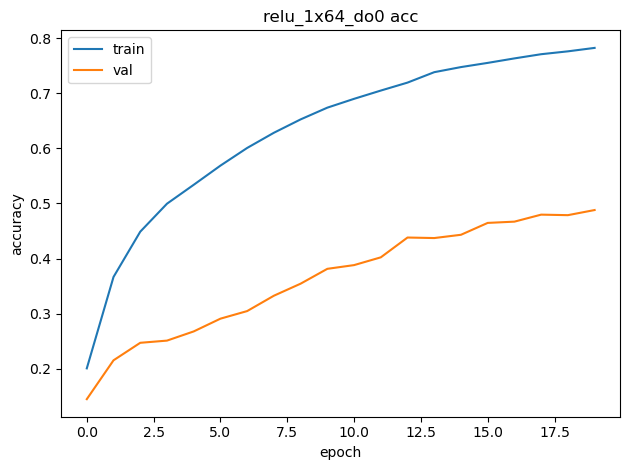

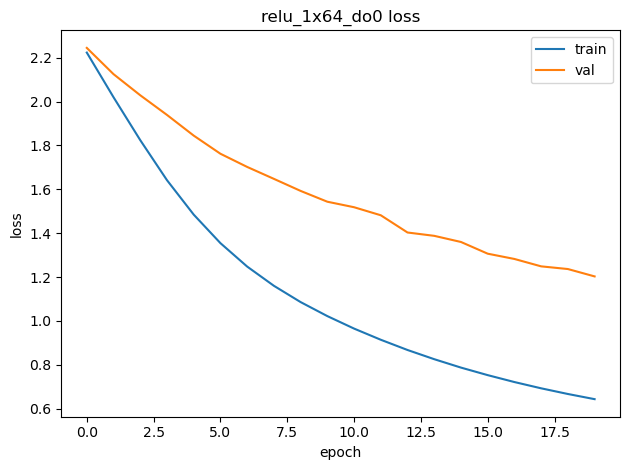

2025-10-26 15:09:48.591597: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


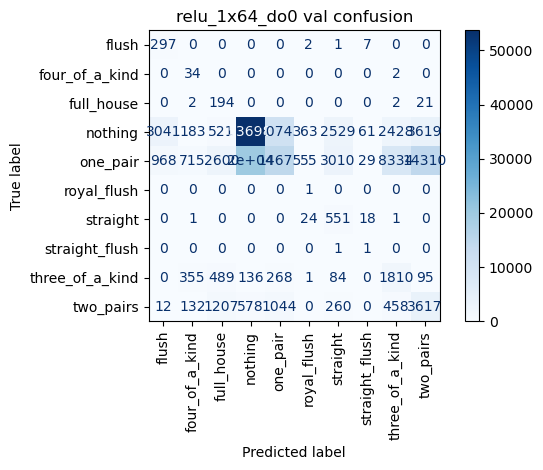

[2/14] relu_2x128_do0
Epoch 1/20
20/20 [==============================] - 1s 23ms/step - loss: 2.1328 - accuracy: 0.3225 - val_loss: 2.1580 - val_accuracy: 0.1484
Epoch 2/20
20/20 [==============================] - 1s 36ms/step - loss: 1.6540 - accuracy: 0.4998 - val_loss: 1.8531 - val_accuracy: 0.2283
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2175 - accuracy: 0.5950 - val_loss: 1.6352 - val_accuracy: 0.2609
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 0.9457 - accuracy: 0.6807 - val_loss: 1.4063 - val_accuracy: 0.4148
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 0.7691 - accuracy: 0.7421 - val_loss: 1.2705 - val_accuracy: 0.4697
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 0.6465 - accuracy: 0.7745 - val_loss: 1.1824 - val_accuracy: 0.4883
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 0.5610 - accuracy: 0.7968 - val_loss: 1.0786 - val_accuracy: 0.5

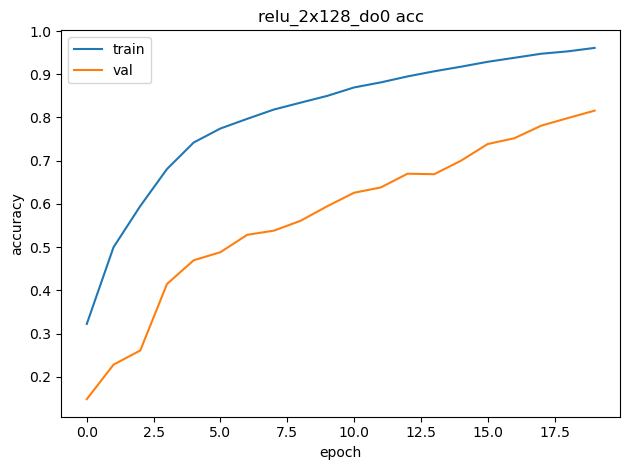

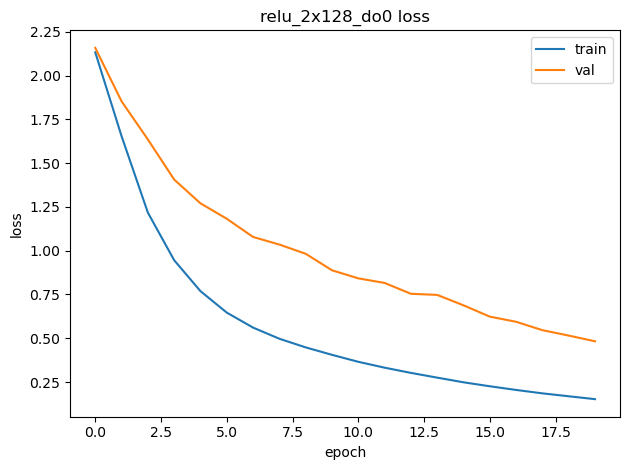

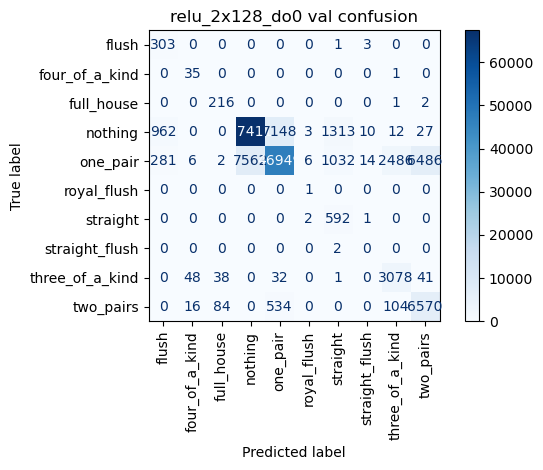

[3/14] relu_3x256_do0
Epoch 1/20
20/20 [==============================] - 1s 22ms/step - loss: 1.8320 - accuracy: 0.4565 - val_loss: 1.7514 - val_accuracy: 0.2355
Epoch 2/20
20/20 [==============================] - 1s 40ms/step - loss: 0.9439 - accuracy: 0.6714 - val_loss: 1.3851 - val_accuracy: 0.4093
Epoch 3/20
20/20 [==============================] - 0s 13ms/step - loss: 0.6002 - accuracy: 0.7778 - val_loss: 1.0864 - val_accuracy: 0.5064
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.4427 - accuracy: 0.8309 - val_loss: 0.9157 - val_accuracy: 0.5945
Epoch 5/20
20/20 [==============================] - 0s 12ms/step - loss: 0.3443 - accuracy: 0.8685 - val_loss: 0.7678 - val_accuracy: 0.6659
Epoch 6/20
20/20 [==============================] - 0s 10ms/step - loss: 0.2661 - accuracy: 0.9026 - val_loss: 0.6101 - val_accuracy: 0.7429
Epoch 7/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1983 - accuracy: 0.9373 - val_loss: 0.5198 - val_accuracy:

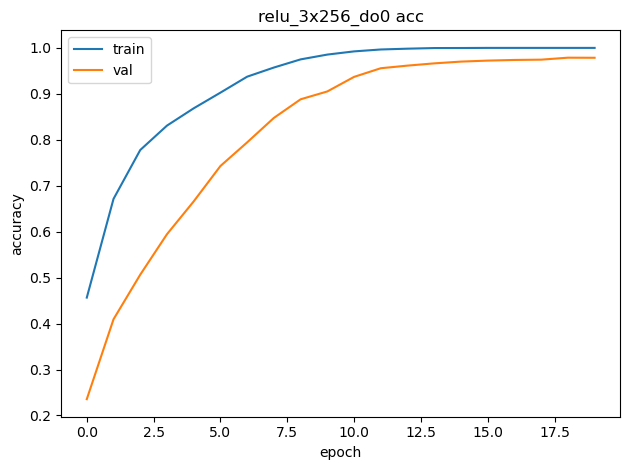

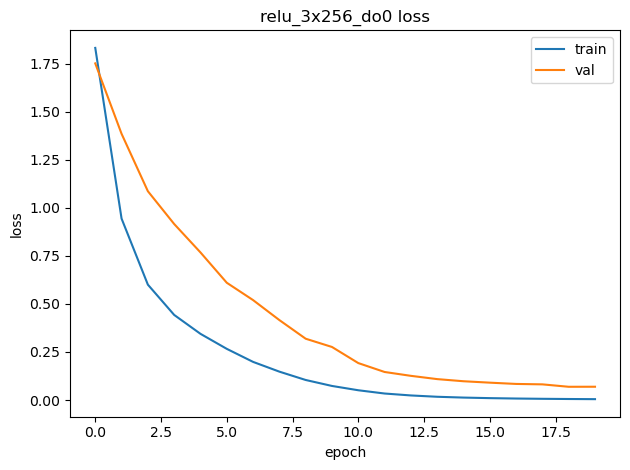

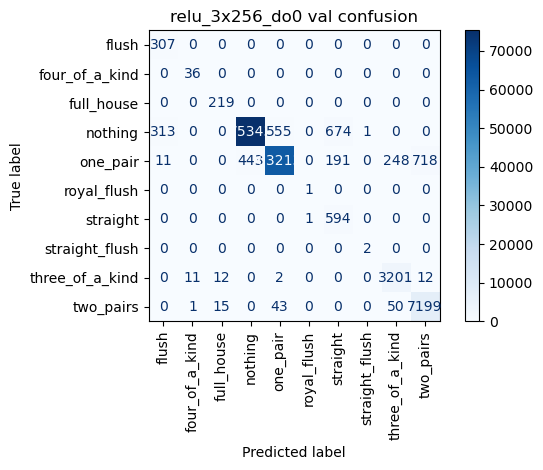

[4/14] relu_1x128_do02
Epoch 1/20
20/20 [==============================] - 1s 24ms/step - loss: 2.2193 - accuracy: 0.2138 - val_loss: 2.2354 - val_accuracy: 0.1717
Epoch 2/20
20/20 [==============================] - 1s 30ms/step - loss: 1.9441 - accuracy: 0.4117 - val_loss: 2.1186 - val_accuracy: 0.2274
Epoch 3/20
20/20 [==============================] - 0s 12ms/step - loss: 1.6955 - accuracy: 0.4880 - val_loss: 1.9455 - val_accuracy: 0.2908
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.4765 - accuracy: 0.5372 - val_loss: 1.8202 - val_accuracy: 0.2990
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.3032 - accuracy: 0.5750 - val_loss: 1.6994 - val_accuracy: 0.3263
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1783 - accuracy: 0.6099 - val_loss: 1.6337 - val_accuracy: 0.3524
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 1.0800 - accuracy: 0.6452 - val_loss: 1.5685 - val_accuracy: 0

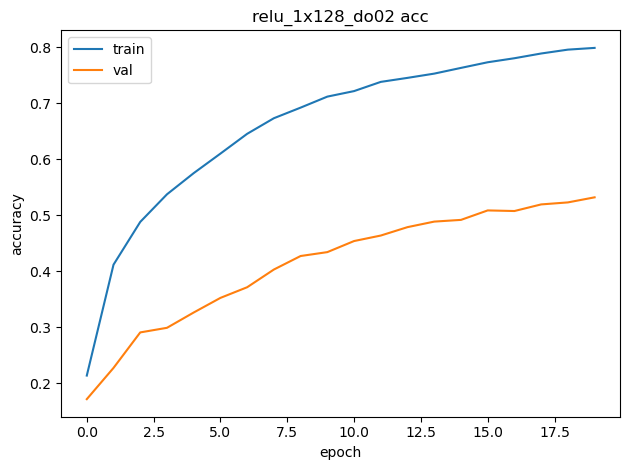

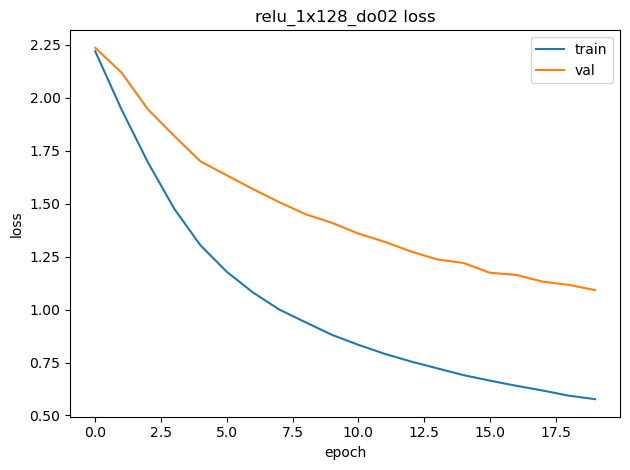

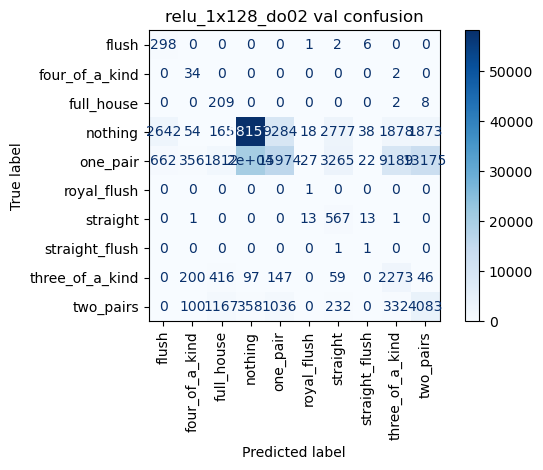

[5/14] relu_2x256_do02
Epoch 1/20
20/20 [==============================] - 1s 22ms/step - loss: 1.9641 - accuracy: 0.3826 - val_loss: 1.9533 - val_accuracy: 0.2990
Epoch 2/20
20/20 [==============================] - 1s 34ms/step - loss: 1.3161 - accuracy: 0.5601 - val_loss: 1.5523 - val_accuracy: 0.3812
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.9499 - accuracy: 0.6636 - val_loss: 1.3707 - val_accuracy: 0.4390
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.7578 - accuracy: 0.7290 - val_loss: 1.1582 - val_accuracy: 0.5108
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 0.6350 - accuracy: 0.7671 - val_loss: 1.0561 - val_accuracy: 0.5499
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 0.5523 - accuracy: 0.7934 - val_loss: 0.9651 - val_accuracy: 0.5754
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 0.4855 - accuracy: 0.8159 - val_loss: 0.8939 - val_accuracy: 0.

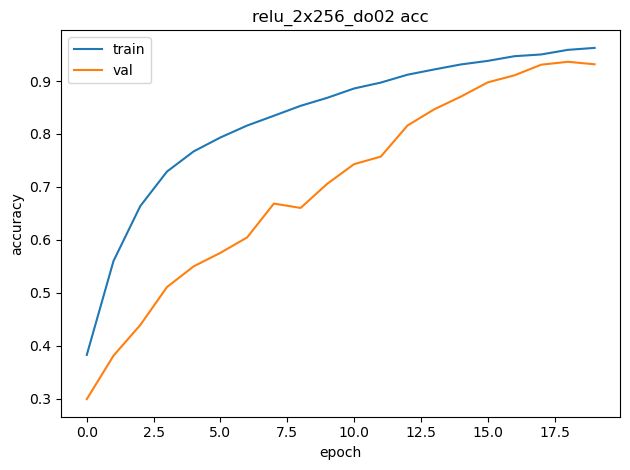

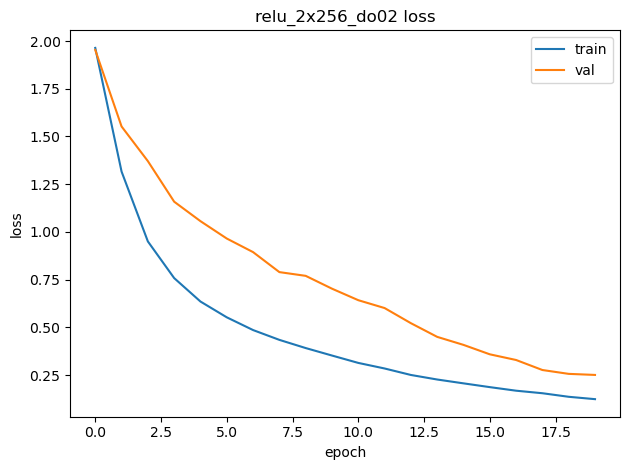

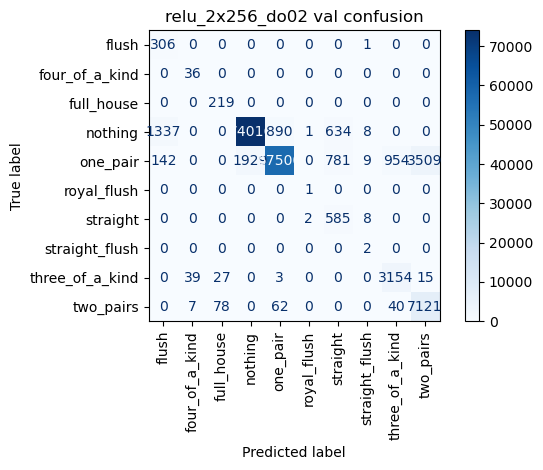

[6/14] relu_3x256_do03
Epoch 1/20
20/20 [==============================] - 1s 32ms/step - loss: 2.0155 - accuracy: 0.3241 - val_loss: 1.9165 - val_accuracy: 0.2347
Epoch 2/20
20/20 [==============================] - 1s 67ms/step - loss: 1.3245 - accuracy: 0.5124 - val_loss: 1.5108 - val_accuracy: 0.3304
Epoch 3/20
20/20 [==============================] - 0s 12ms/step - loss: 0.9348 - accuracy: 0.6503 - val_loss: 1.2924 - val_accuracy: 0.4537
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 0.7339 - accuracy: 0.7197 - val_loss: 1.0714 - val_accuracy: 0.5277
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 0.6159 - accuracy: 0.7618 - val_loss: 0.9290 - val_accuracy: 0.5906
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 0.5316 - accuracy: 0.7923 - val_loss: 0.8053 - val_accuracy: 0.6458
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 0.4569 - accuracy: 0.8189 - val_loss: 0.6884 - val_accuracy: 

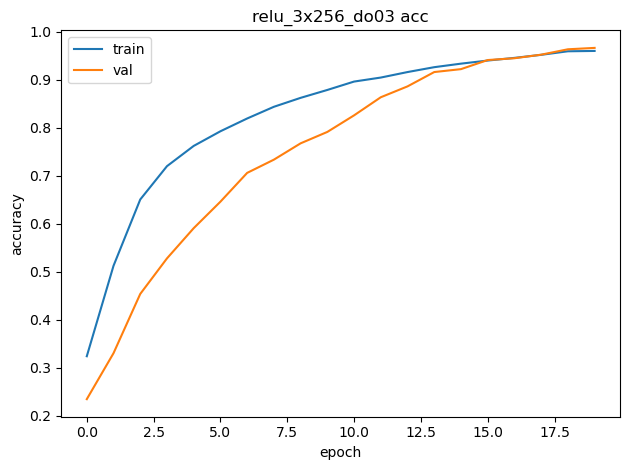

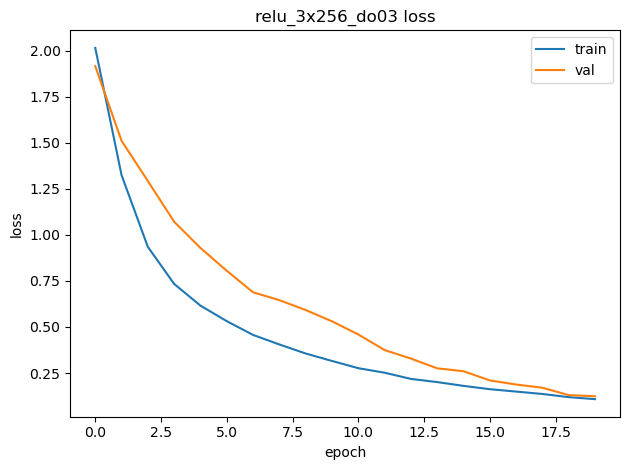

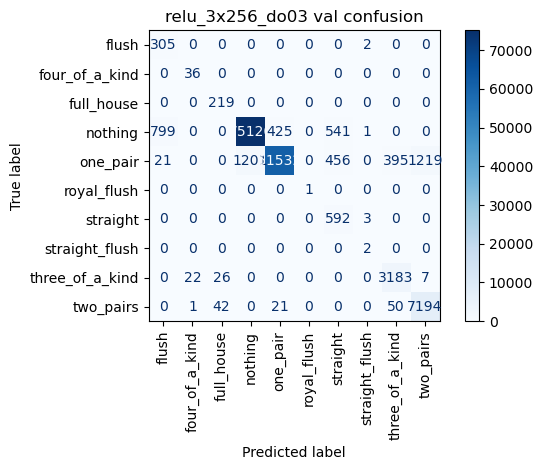

[7/14] tanh_1x128_do0
Epoch 1/20
20/20 [==============================] - 1s 20ms/step - loss: 2.1302 - accuracy: 0.2472 - val_loss: 2.1321 - val_accuracy: 0.1799
Epoch 2/20
20/20 [==============================] - 1s 29ms/step - loss: 1.7705 - accuracy: 0.4238 - val_loss: 1.9756 - val_accuracy: 0.2155
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 1.5495 - accuracy: 0.4850 - val_loss: 1.8652 - val_accuracy: 0.2128
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.4003 - accuracy: 0.5178 - val_loss: 1.7937 - val_accuracy: 0.2174
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2983 - accuracy: 0.5466 - val_loss: 1.7342 - val_accuracy: 0.2484
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2258 - accuracy: 0.5543 - val_loss: 1.6707 - val_accuracy: 0.2507
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1719 - accuracy: 0.5702 - val_loss: 1.6555 - val_accuracy: 0.2

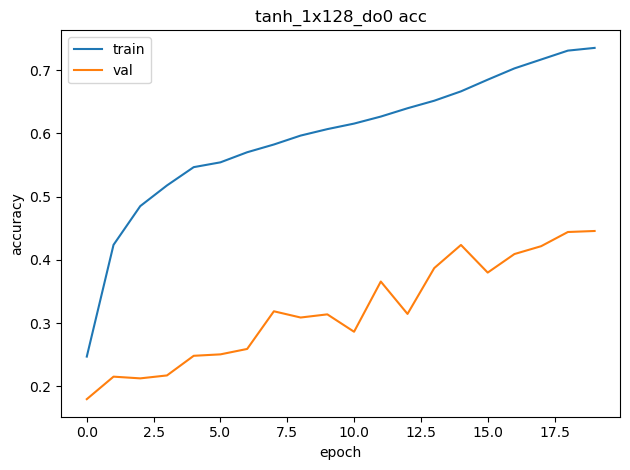

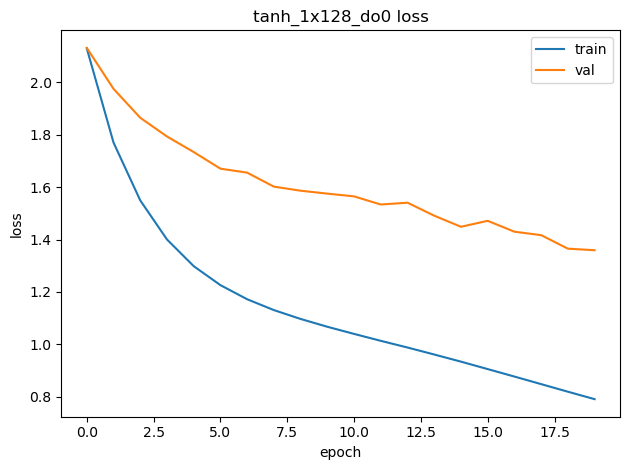

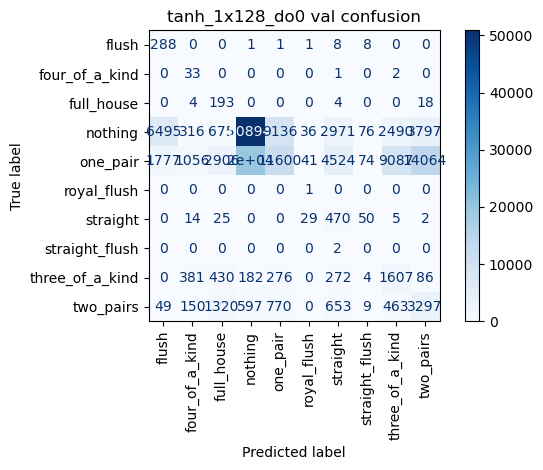

[8/14] tanh_2x128_do0
Epoch 1/20
20/20 [==============================] - 2s 31ms/step - loss: 1.9752 - accuracy: 0.3266 - val_loss: 2.0286 - val_accuracy: 0.1627
Epoch 2/20
20/20 [==============================] - 1s 32ms/step - loss: 1.4684 - accuracy: 0.5025 - val_loss: 1.7484 - val_accuracy: 0.2912
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 1.2368 - accuracy: 0.5541 - val_loss: 1.6874 - val_accuracy: 0.2756
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1167 - accuracy: 0.5889 - val_loss: 1.5881 - val_accuracy: 0.3594
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.0391 - accuracy: 0.6193 - val_loss: 1.5445 - val_accuracy: 0.4021
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 0.9721 - accuracy: 0.6514 - val_loss: 1.4722 - val_accuracy: 0.3990
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 0.9036 - accuracy: 0.6883 - val_loss: 1.4802 - val_accuracy: 0.3

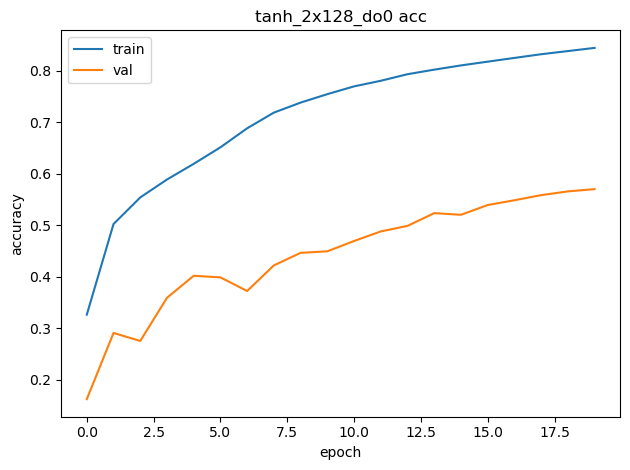

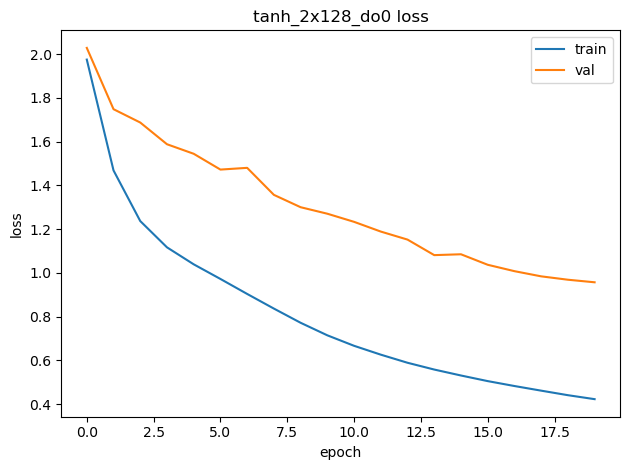

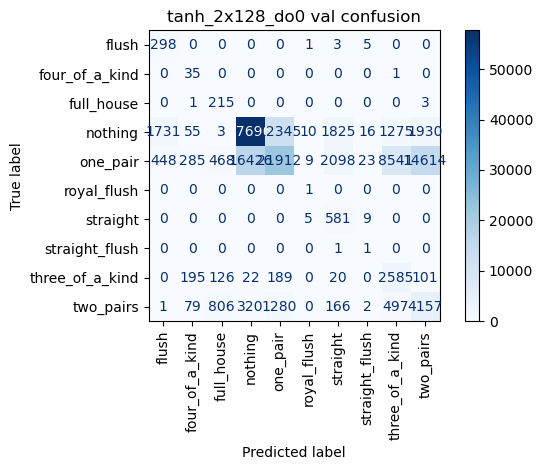

[9/14] tanh_1x256_do02
Epoch 1/20
20/20 [==============================] - 1s 21ms/step - loss: 2.0186 - accuracy: 0.3126 - val_loss: 2.0993 - val_accuracy: 0.1915
Epoch 2/20
20/20 [==============================] - 1s 30ms/step - loss: 1.6134 - accuracy: 0.4794 - val_loss: 1.8739 - val_accuracy: 0.2660
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 1.3998 - accuracy: 0.5240 - val_loss: 1.7694 - val_accuracy: 0.2392
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2785 - accuracy: 0.5434 - val_loss: 1.7090 - val_accuracy: 0.2471
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2020 - accuracy: 0.5570 - val_loss: 1.6492 - val_accuracy: 0.2977
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1495 - accuracy: 0.5672 - val_loss: 1.6178 - val_accuracy: 0.2824
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1122 - accuracy: 0.5767 - val_loss: 1.6113 - val_accuracy: 0.

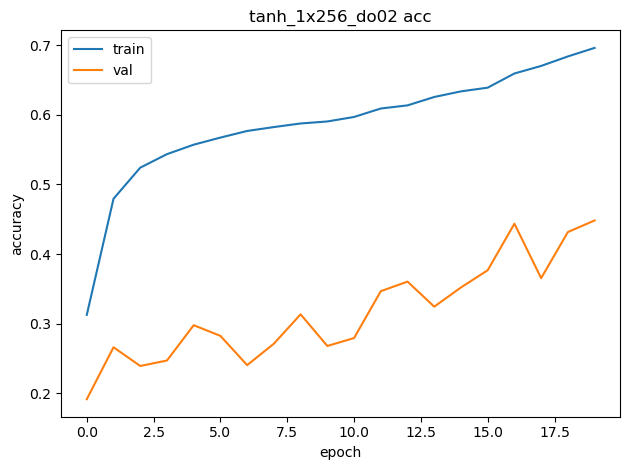

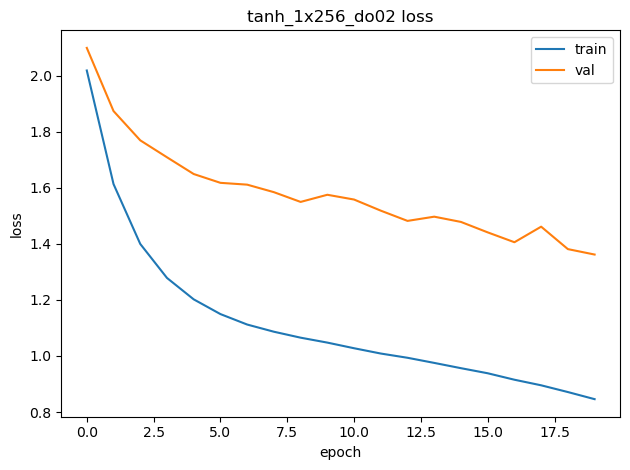

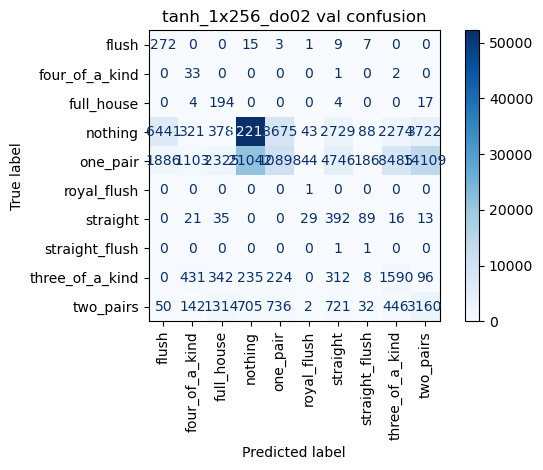

[10/14] tanh_2x256_do02
Epoch 1/20
20/20 [==============================] - 1s 22ms/step - loss: 1.7906 - accuracy: 0.3832 - val_loss: 1.8488 - val_accuracy: 0.1898
Epoch 2/20
20/20 [==============================] - 1s 36ms/step - loss: 1.2933 - accuracy: 0.5275 - val_loss: 1.6429 - val_accuracy: 0.3229
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 1.1459 - accuracy: 0.5608 - val_loss: 1.6458 - val_accuracy: 0.1650
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 1.0808 - accuracy: 0.5780 - val_loss: 1.5955 - val_accuracy: 0.2235
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.0320 - accuracy: 0.6013 - val_loss: 1.5136 - val_accuracy: 0.3440
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 0.9796 - accuracy: 0.6289 - val_loss: 1.4612 - val_accuracy: 0.4337
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 0.9229 - accuracy: 0.6635 - val_loss: 1.4333 - val_accuracy:

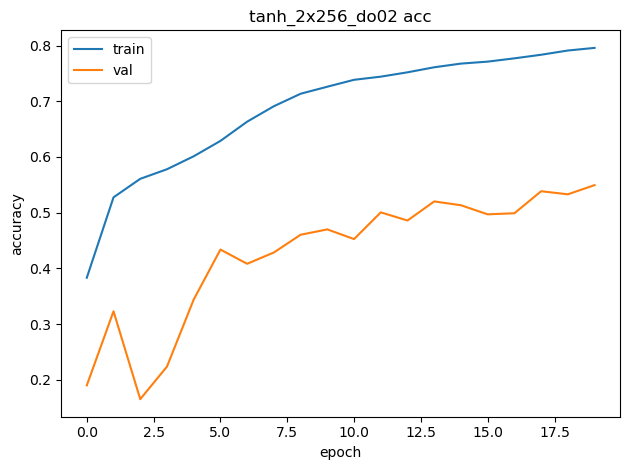

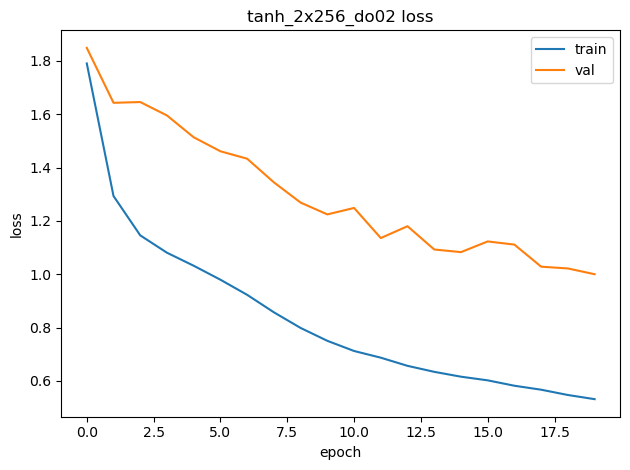

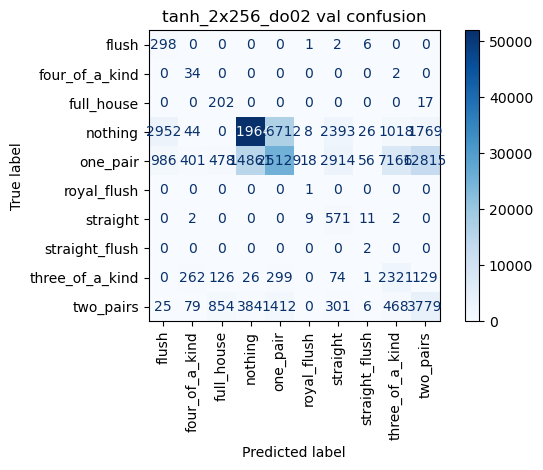

[11/14] sigmoid_1x128_do0
Epoch 1/20
20/20 [==============================] - 1s 24ms/step - loss: 2.3065 - accuracy: 0.1652 - val_loss: 2.3618 - val_accuracy: 0.0157
Epoch 2/20
20/20 [==============================] - 1s 33ms/step - loss: 2.1482 - accuracy: 0.3063 - val_loss: 2.2628 - val_accuracy: 0.1087
Epoch 3/20
20/20 [==============================] - 0s 11ms/step - loss: 2.0435 - accuracy: 0.4105 - val_loss: 2.2062 - val_accuracy: 0.1284
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.9473 - accuracy: 0.4400 - val_loss: 2.1777 - val_accuracy: 0.0898
Epoch 5/20
20/20 [==============================] - 0s 11ms/step - loss: 1.8564 - accuracy: 0.4527 - val_loss: 2.1240 - val_accuracy: 0.1114
Epoch 6/20
20/20 [==============================] - 0s 13ms/step - loss: 1.7721 - accuracy: 0.4715 - val_loss: 2.1161 - val_accuracy: 0.0475
Epoch 7/20
20/20 [==============================] - 0s 11ms/step - loss: 1.6945 - accuracy: 0.4797 - val_loss: 2.0321 - val_accur

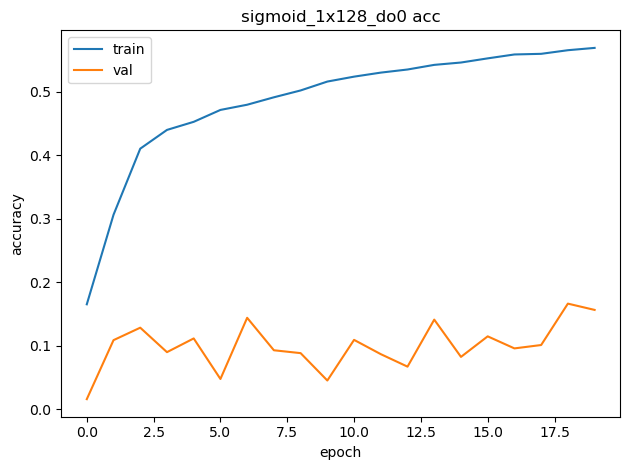

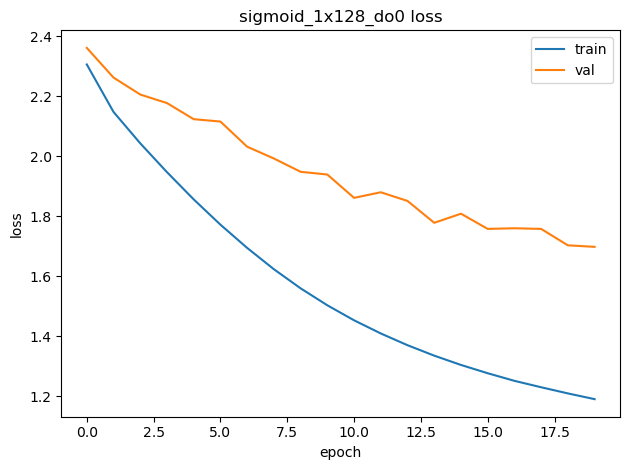

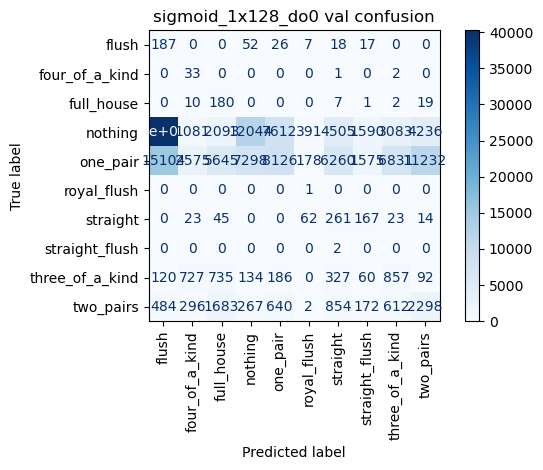

[12/14] sigmoid_2x128_do0
Epoch 1/20
20/20 [==============================] - 1s 26ms/step - loss: 2.3136 - accuracy: 0.1207 - val_loss: 2.2981 - val_accuracy: 5.1494e-04
Epoch 2/20
20/20 [==============================] - 1s 34ms/step - loss: 2.2565 - accuracy: 0.2111 - val_loss: 2.2628 - val_accuracy: 0.0593
Epoch 3/20
20/20 [==============================] - 0s 11ms/step - loss: 2.1936 - accuracy: 0.3058 - val_loss: 2.2415 - val_accuracy: 0.1573
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 2.0950 - accuracy: 0.3419 - val_loss: 2.2317 - val_accuracy: 0.0490
Epoch 5/20
20/20 [==============================] - 0s 11ms/step - loss: 1.9708 - accuracy: 0.3862 - val_loss: 2.2326 - val_accuracy: 0.0216
Epoch 6/20
20/20 [==============================] - 0s 11ms/step - loss: 1.8449 - accuracy: 0.4028 - val_loss: 2.1062 - val_accuracy: 0.0319
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 1.7255 - accuracy: 0.4284 - val_loss: 2.0509 - val_a

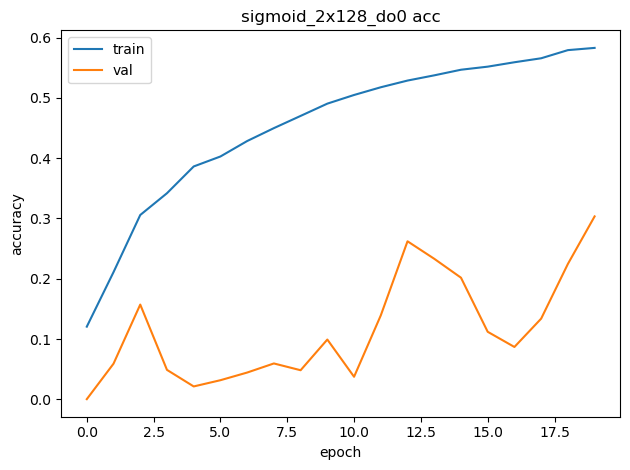

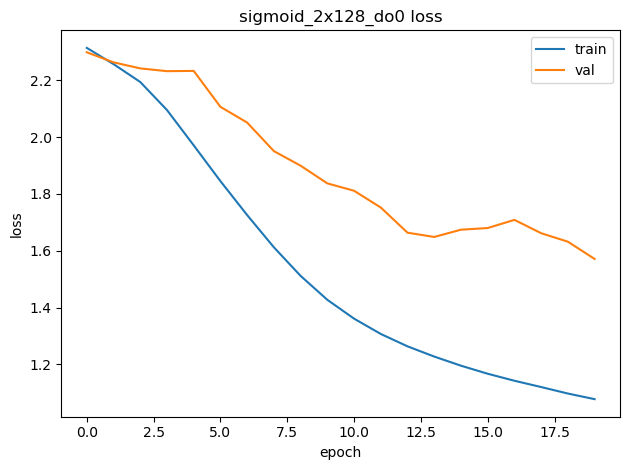

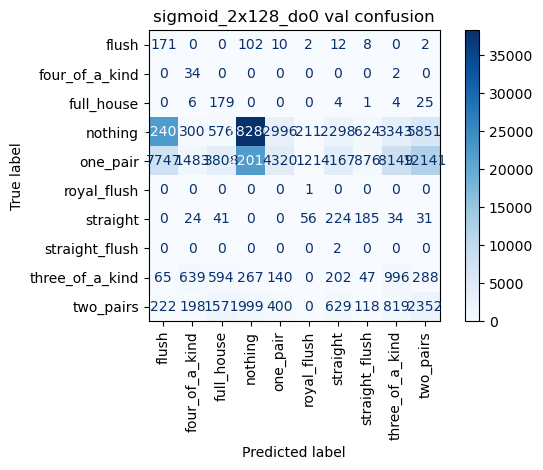

[13/14] sigmoid_1x256_do02
Epoch 1/20
20/20 [==============================] - 1s 20ms/step - loss: 2.3435 - accuracy: 0.1363 - val_loss: 2.3149 - val_accuracy: 0.0123
Epoch 2/20
20/20 [==============================] - 1s 31ms/step - loss: 2.1628 - accuracy: 0.2418 - val_loss: 2.2588 - val_accuracy: 0.0805
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 2.0354 - accuracy: 0.3142 - val_loss: 2.1294 - val_accuracy: 0.2465
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.9221 - accuracy: 0.3600 - val_loss: 2.0983 - val_accuracy: 0.2150
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.8205 - accuracy: 0.3915 - val_loss: 2.0060 - val_accuracy: 0.2037
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.7281 - accuracy: 0.4192 - val_loss: 1.9846 - val_accuracy: 0.2220
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 1.6499 - accuracy: 0.4378 - val_loss: 1.8958 - val_accuracy

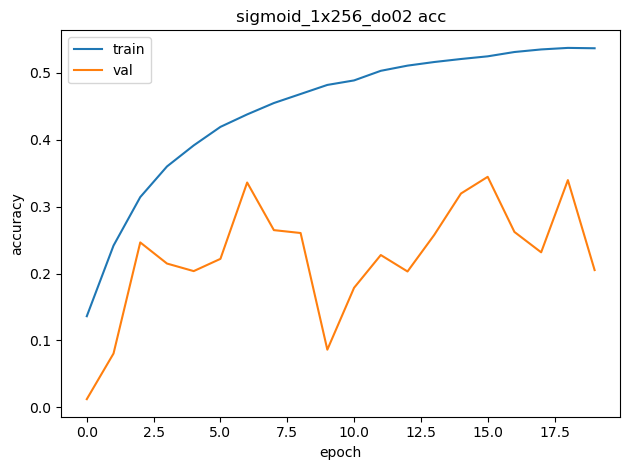

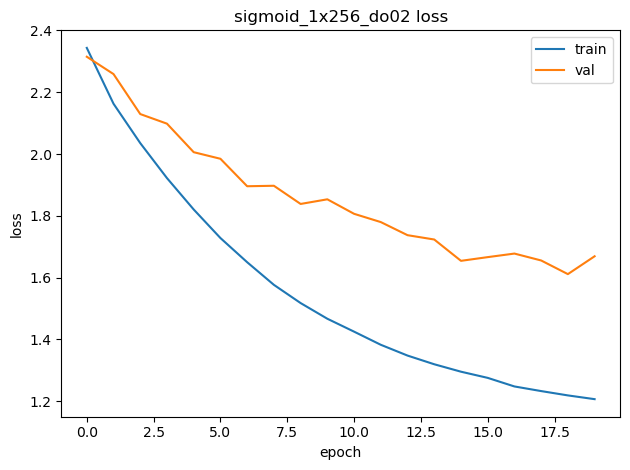

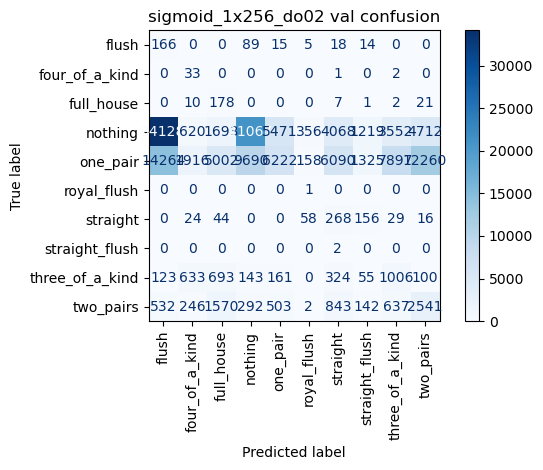

[14/14] sigmoid_2x256_do03
Epoch 1/20
20/20 [==============================] - 1s 22ms/step - loss: 2.4002 - accuracy: 0.1094 - val_loss: 2.4120 - val_accuracy: 0.0037
Epoch 2/20
20/20 [==============================] - 1s 34ms/step - loss: 2.2989 - accuracy: 0.1425 - val_loss: 2.3818 - val_accuracy: 0.0027
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 2.1968 - accuracy: 0.2090 - val_loss: 2.2887 - val_accuracy: 0.1498
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 2.0707 - accuracy: 0.2632 - val_loss: 2.2069 - val_accuracy: 0.1852
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 1.9301 - accuracy: 0.3156 - val_loss: 2.0298 - val_accuracy: 0.3673
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 1.8030 - accuracy: 0.3580 - val_loss: 1.9669 - val_accuracy: 0.2816
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 1.6820 - accuracy: 0.3959 - val_loss: 1.8446 - val_accuracy

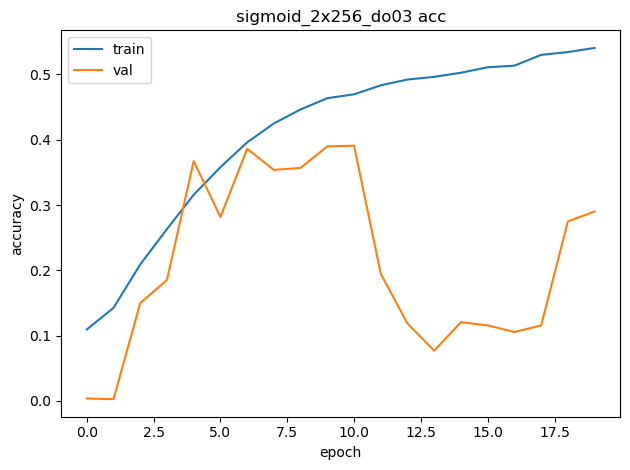

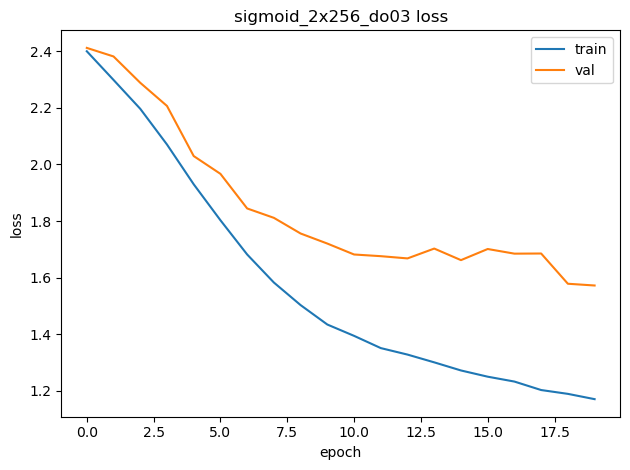

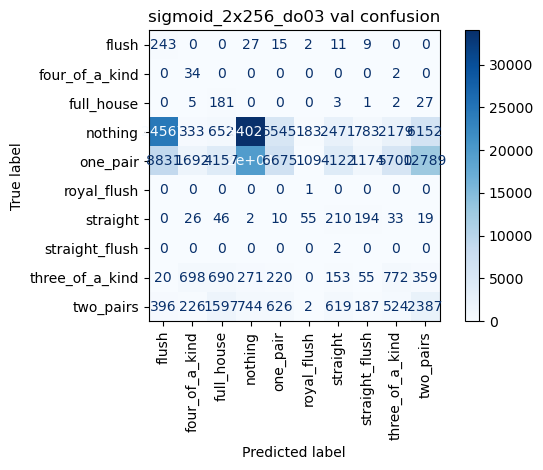

best by macro f1 relu_3x256_do0 0.8363727961341638


In [6]:
best_name = None
best_metric = -1.0
results = []
histories = {}          # store curves for combined plots
confusions = {}         # store cm arrays for later display

EPOCHS = 20

for i, cfg in enumerate(configs, 1):
    print(f'[{i}/{len(configs)}] {cfg["name"]}')
    model = build_model(X_train.shape[1], cfg, num_classes)
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )

    histories[cfg['name']] = {
        'act': cfg['act'],
        'val_accuracy': hist.history.get('val_accuracy', []),
        'val_loss': hist.history.get('val_loss', []),
        'train_accuracy': hist.history.get('accuracy', []),
        'train_loss': hist.history.get('loss', [])
    }

    # per run plots show and save
    acc_path  = f"../artifacts/experiments/{cfg['name']}_acc.png"
    loss_path = f"../artifacts/experiments/{cfg['name']}_loss.png"
    plt.figure(); plt.plot(hist.history['accuracy']); plt.plot(hist.history['val_accuracy']); plt.legend(['train','val']); plt.title(cfg['name']+' acc'); plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.tight_layout(); plt.savefig(acc_path, dpi=150); plt.show()
    plt.figure(); plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']); plt.legend(['train','val']); plt.title(cfg['name']+' loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.tight_layout(); plt.savefig(loss_path, dpi=150); plt.show()

    # val metrics
    yv_pred = model.predict(X_val, batch_size=4096, verbose=0).argmax(1)
    macro_f1 = f1_score(y_val, yv_pred, average='macro')
    val_acc  = float(np.mean(yv_pred == y_val))

    # confusion matrix save and keep for end
    cm = confusion_matrix(y_val, yv_pred)
    confusions[cfg['name']] = cm
    disp = ConfusionMatrixDisplay(cm, display_labels=meta['label_classes'])
    disp.plot(xticks_rotation=90, cmap='Blues')
    plt.title(cfg['name']+' val confusion')
    plt.tight_layout()
    plt.savefig(f"../artifacts/experiments/{cfg['name']}_val_confusion.png", dpi=150)
    plt.show()

    # classification report
    rep = classification_report(y_val, yv_pred, target_names=meta['label_classes'])
    with open(f"../artifacts/experiments/{cfg['name']}_val_report.txt",'w') as f: f.write(rep)

    results.append({'name':cfg['name'],'layers':cfg['layers'],'act':cfg['act'],'dropout':cfg['dropout'],'val_acc':val_acc,'macro_f1':float(macro_f1)})

    if macro_f1 > best_metric:
        best_metric = macro_f1
        best_name = cfg['name']
        model.save('../artifacts/best_so_far.keras')
        with open('../artifacts/best_so_far_name.txt','w') as f: f.write(best_name)

# save summary json
with open('../artifacts/experiments/results.json','w') as f:
    json.dump(results, f, indent=2)

print('best by macro f1', best_name, best_metric)


## Combined plots per activation
show and save combined validation curves per activation group

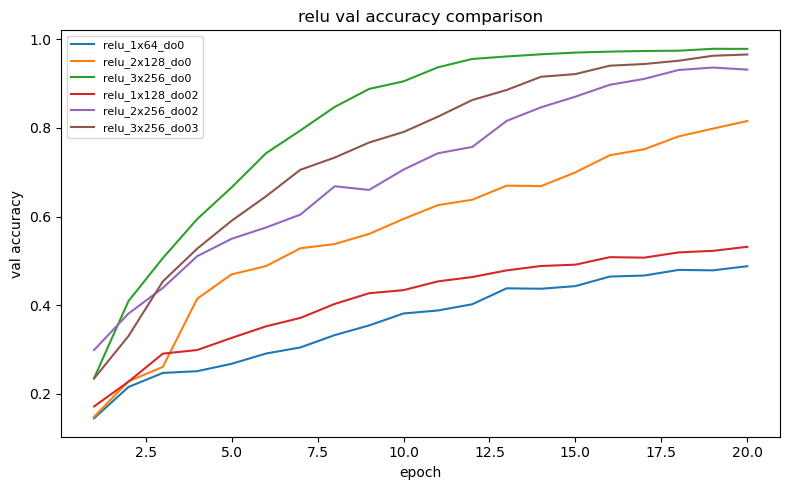

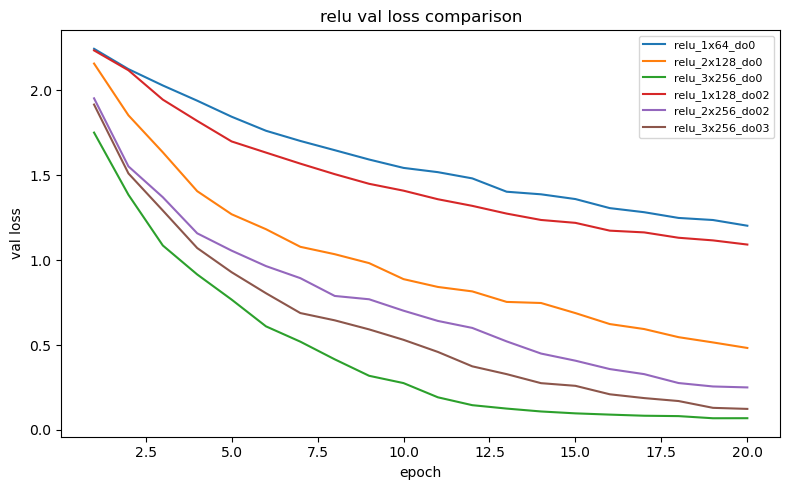

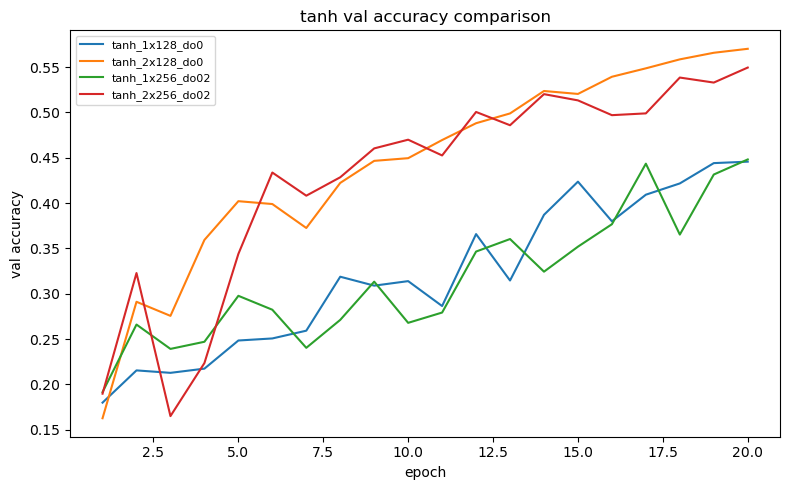

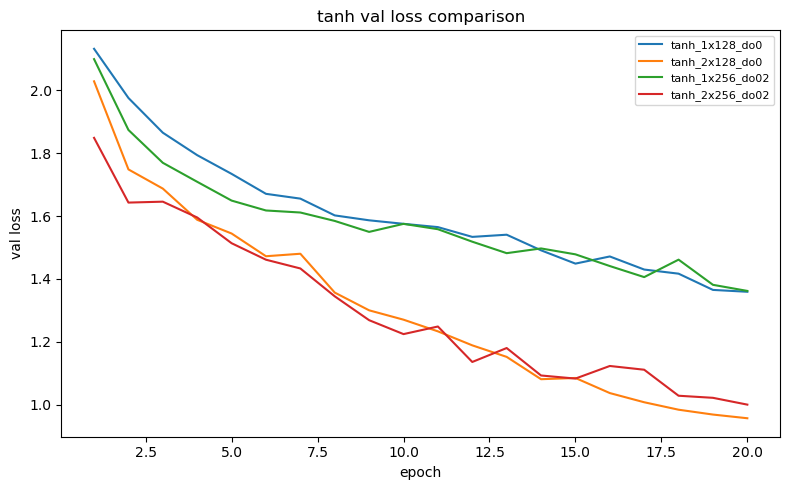

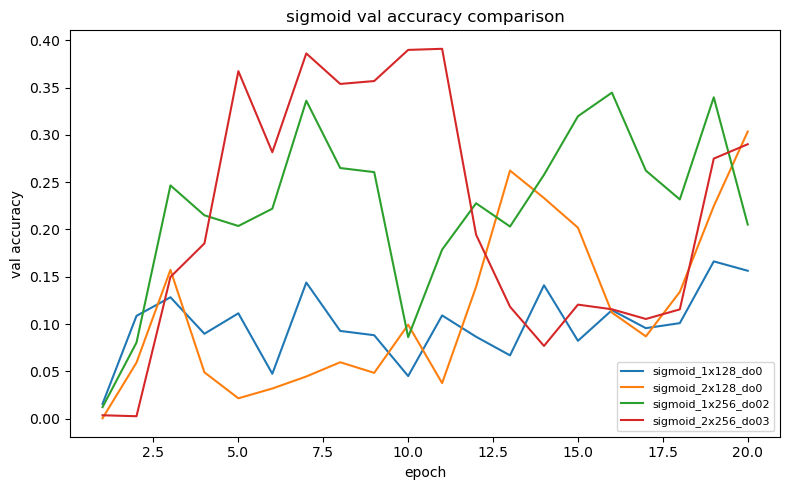

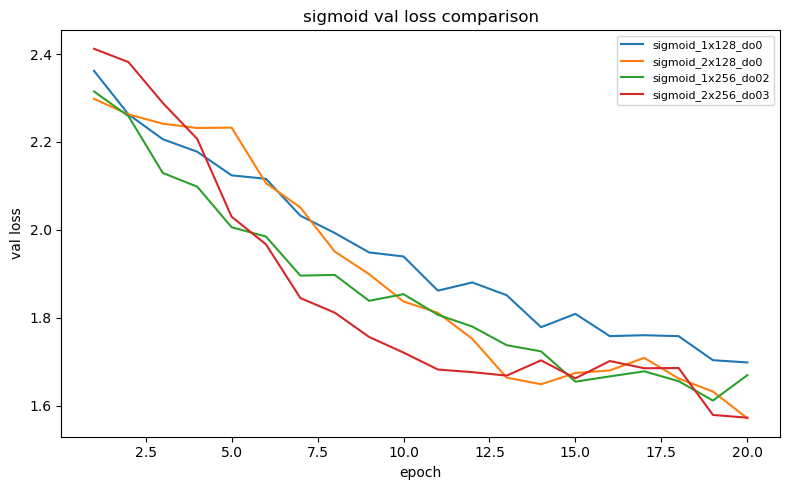

In [7]:
# group names by activation
by_act = {}
for name, h in histories.items():
    act = h['act']
    by_act.setdefault(act, []).append(name)

# make combined plots for each activation
for act, names in by_act.items():
    # val accuracy
    plt.figure(figsize=(8,5))
    for name in names:
        vals = histories[name]['val_accuracy']
        plt.plot(range(1, len(vals)+1), vals, label=name)
    plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title(f'{act} val accuracy comparison'); plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../artifacts/experiments/combined_val_accuracy_{act}.png', dpi=150)
    plt.show()

    # val loss
    plt.figure(figsize=(8,5))
    for name in names:
        vals = histories[name]['val_loss']
        plt.plot(range(1, len(vals)+1), vals, label=name)
    plt.xlabel('epoch'); plt.ylabel('val loss'); plt.title(f'{act} val loss comparison'); plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../artifacts/experiments/combined_val_loss_{act}.png', dpi=150)
    plt.show()


## Overall combined plots
compare top models by macro f1

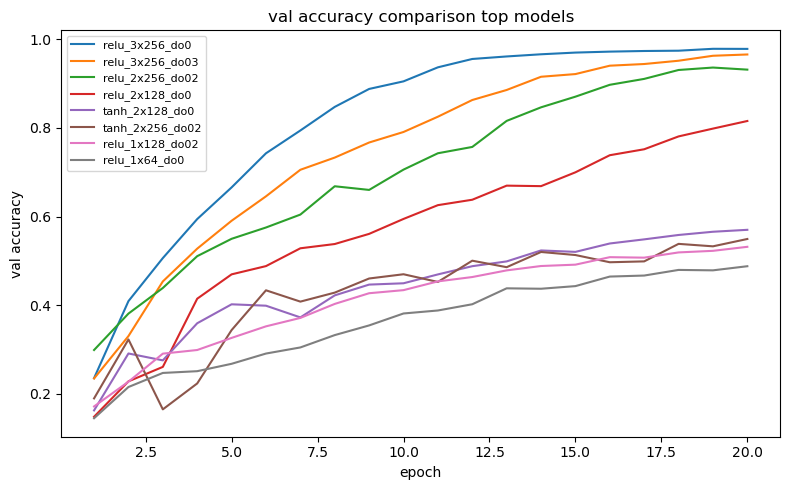

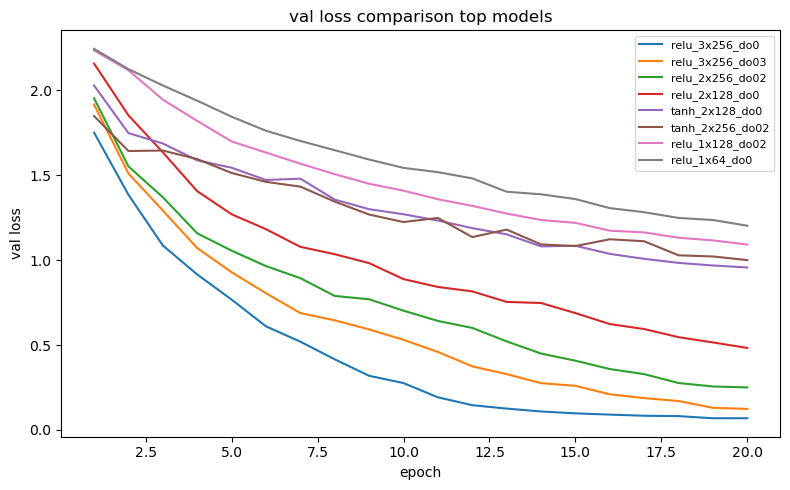

In [8]:
names_sorted = [r['name'] for r in sorted(results, key=lambda x: x['macro_f1'], reverse=True)]
top_names = names_sorted[:8]

plt.figure(figsize=(8,5))
for name in top_names:
    vals = histories[name]['val_accuracy']
    plt.plot(range(1, len(vals)+1), vals, label=name)
plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title('val accuracy comparison top models'); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../artifacts/experiments/combined_val_accuracy_top.png', dpi=150)
plt.show()

plt.figure(figsize=(8,5))
for name in top_names:
    vals = histories[name]['val_loss']
    plt.plot(range(1, len(vals)+1), vals, label=name)
plt.xlabel('epoch'); plt.ylabel('val loss'); plt.title('val loss comparison top models'); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../artifacts/experiments/combined_val_loss_top.png', dpi=150)
plt.show()


## Visualize results json
show bar charts of val accuracy and macro f1 sorted by macro f1

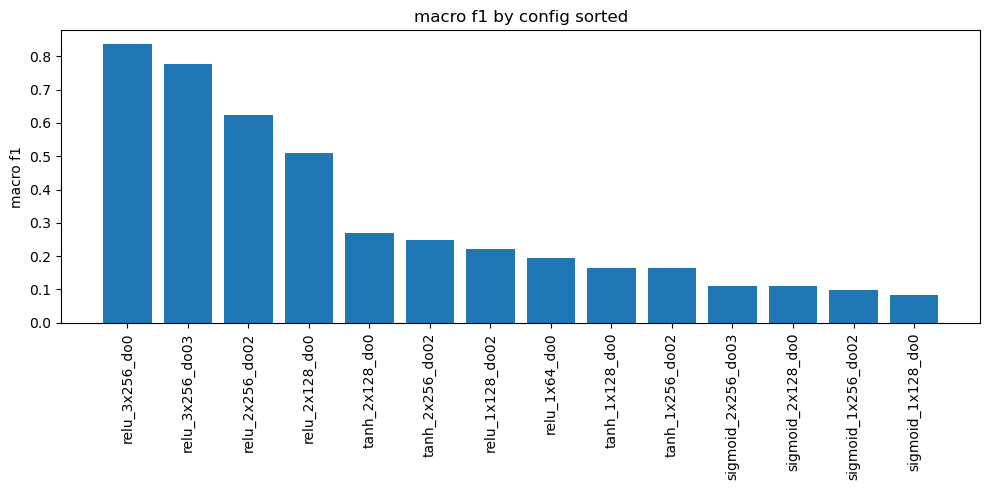

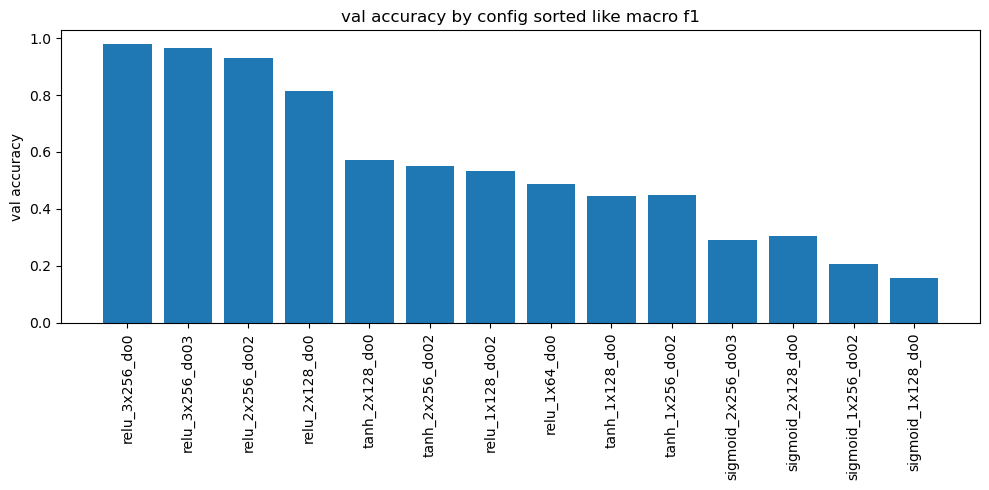

In [9]:
# ensure results is loaded if this cell runs alone
if 'results' not in globals():
    with open('../artifacts/experiments/results.json') as f:
        results = json.load(f)

# sort by macro f1
results_sorted = sorted(results, key=lambda x: x['macro_f1'], reverse=True)
names = [r['name'] for r in results_sorted]
val_accs = [r['val_acc'] for r in results_sorted]
macro_f1s = [r['macro_f1'] for r in results_sorted]

# macro f1 bar
plt.figure(figsize=(10,5))
plt.bar(range(len(names)), macro_f1s)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('macro f1'); plt.title('macro f1 by config sorted')
plt.tight_layout()
plt.savefig('../artifacts/experiments/results_macro_f1.png', dpi=150)
plt.show()

# val acc bar
plt.figure(figsize=(10,5))
plt.bar(range(len(names)), val_accs)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('val accuracy'); plt.title('val accuracy by config sorted like macro f1')
plt.tight_layout()
plt.savefig('../artifacts/experiments/results_val_acc.png', dpi=150)
plt.show()
